In [127]:
!pip install --upgrade pip
!pip install -r ../requirements.txt

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [129]:
# Fuente: https://www.kaggle.com/datasets/adityaramachandran27/nasa-near-earth-objects-information

In [130]:
!unzip ../data/nasa_neo.zip
!mv nasa_neo.csv ../data

Archive:  ../data/nasa_neo.zip
replace NASA Near-Earth Objects.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
mv: cannot stat 'nasa_neo.csv': No such file or directory


In [146]:
df_raw = pd.read_csv('../data/nasa_neo.csv')

### Objetivos de estudio

- Analizar el dataset, buscar correlaciones entre variables y transformar datos
- Evaluar como solucionar la problematica de que el dataset es desbalanceado en la columna target de interes
- Aplicar algoritmos de clasificacion para determinar si un NEO tiene peligro potencial de impacto

### Diccionario de datos:

- Unnamed: 0: Default index

- id: A unique ID given by NASA

- neo_reference_id: A unique ID given by NASA to all NEO, same as the ID

- name: Official name given by NASA

- name_limited: Normal name without the scientific notations

- designation: The number used in the official name given by NASA

- absolute_magnitude_h: Absolute magnitude (M) is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical

- is_potentially_hazardous_asteroid: Boolean value which tells if the object poses a threat to earth or not

- is_sentry_object: Boolean value which tells if the object is present in the sentry tracking system or not (Sentry: https://en.wikipedia.org/wiki/Sentry_(monitoring_system))

- kilometers_estimated_diameter_min: Minimum estimated diameter in kilometer

- kilometers_estimated_diameter_max: Maximum estimated diameter in kilometer

- orbit_id: A unique ID for the orbit of the object

- orbit_class_type: Classification of the object orbit into classes

    - (AMO is referring to Amor asteroids: near-Earth asteroids. The orbital perihelion of these objects is close to, but greater than, the orbital aphelion of Earth (a > 1.0 AU and 1.017 AU < q < 1.3 AU).

    - APO is referring to Apollo asteroids: near-Earth asteroid orbits which cross the Earth's orbit (a > 1.0 AU and q < 1.017 AU).)

    - (Abajo hay mas info sobre el tema, incluyendo las orbitas de tipo ATE e IEO)

- perihelion_distance: Has the perihelion distance (the point nearest to the Earth in the path of an orbiting celestial body)

- aphelion_distance: Has the aphelion distance (the point in the orbit of a planet, asteroid, or object at which it is furthest from the Earth)

- first_observation_date: Date when the object was first observed

- last_observation_date: Date when the object was last observed

- orbit_class_description: The description of the orbit

(Diccionario extrído de la fuente)

Asteroids are dynamically classified as "Near-Earth" if their perihelion distance is less than 1.3 AU. They are further divided into groups based on their semi-major axis (a), perihelion distance (q), and aphelion distance (Q).

- Apollos (APO) cross Earth's orbit and have a semi-major axis of more than 1 AU
- Amors (AMO) have orbits strictly outside Earth's orbit
- Atens (ATE) cross Earth's orbit and have a semi-major axis of less than 1 AU
- Atiras (IEO) have orbits strictly inside Earth's orbit

(Fuente: https://www.comet-toolbox.com/neos.html)

In [147]:
# info del dataset

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

Observar que hay datos faltantes en columnas como 'absolute_magnitude_h ' y 'name_limited'. En el segundo caso es porque NASA no le asigna nombres propios a todos los cuerpos

In [148]:
# Drop de columna Unnamed (index de sobra)

df_raw.drop(columns = ['Unnamed: 0'], inplace = True)

In [149]:
df_raw.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


In [135]:
df_raw.describe(include = ['object','bool'])

,name,name_limited,designation,is_potentially_hazardous_asteroid,is_sentry_object,orbit_id,orbit_class_type,first_observation_date,last_observation_date,orbit_class_description
count,24000,144,24000,24000,24000,24000,24000,24000,24000,24000
unique,24000,144,24000,2,2,352,4,5964,5016,4
top,1981 Midas (1973 EA),Midas,1981,False,False,7,APO,2014-04-23,2022-04-15,Near-Earth asteroid orbits which cross the Ear...
freq,1,1,1,21906,22934,1485,13245,67,40,13245


Podemos ver que la asignacion de nombres por parte de la NASA es unica, ya que en las columnas 'name', 'name_limited' y 'designation' tenemos todos valores unicos. Vamos a chequear tambien en la columna 'id' si se cumple

In [150]:
df_raw['id'].duplicated().any()

False

In [137]:
df_raw.sample(5)

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
23712,54054560,54054560,(2020 SZ2),NaN,2020 SZ2,29.4,False,False,0.003504,0.007835,2,APO,0.886686,2.434870,2020-09-20,2020-09-21,Near-Earth asteroid orbits which cross the Ear...
10913,3669145,3669145,(2014 HT46),NaN,2014 HT46,26.6,False,False,0.012722,0.028447,16,APO,0.982939,1.580889,2014-04-23,2014-05-05,Near-Earth asteroid orbits which cross the Ear...
5130,3353633,3353633,(2006 UE64),NaN,2006 UE64,28.0,False,False,0.006677,0.014929,9,APO,0.812747,1.827571,2006-10-23,2006-10-26,Near-Earth asteroid orbits which cross the Ear...
22152,3991642,3991642,(2020 CA3),NaN,2020 CA3,25.2,False,False,0.024241,0.054205,11,APO,0.974674,1.767450,2020-02-15,2020-03-07,Near-Earth asteroid orbits which cross the Ear...
10615,3656919,3656919,(2014 BG3),NaN,2014 BG3,21.1,False,False,0.160160,0.358129,20,APO,0.733851,1.851787,2014-01-21,2020-01-30,Near-Earth asteroid orbits which cross the Ear...


#### Observaciones

- Las columnas 'id' y 'neo_reference_id' son identicas, asi que nos podemos quedar solo con una de ellas
- La columna 'name_limited' es simplemente la extraccion del nombre propio del cuerpo (si es que lo tiene), dato que ya esta en la columna 'name', por lo que no nos presenta informacion relevante, mas alla de sacar la proporcion de cuerpos a los que la NASA le ha asignado un valor propio. 
- Algo similar sucede con la columna 'designation', la cual tambien es una parte del nombre oficial establecido, y el dato completo del nombre esta en la columna 'name'

In [151]:
df_raw.drop(columns = ['neo_reference_id', 'name_limited', 'designation'], inplace = True)

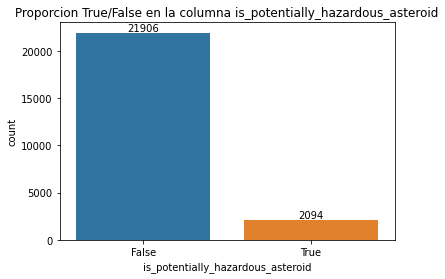

In [152]:
# is_potentially_hazardous_asteroid

ax = sns.countplot(x = df_raw['is_potentially_hazardous_asteroid'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_potentially_hazardous_asteroid')
plt.show()

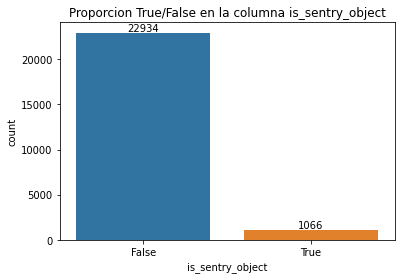

In [140]:
# is_sentry_object

ax = sns.countplot(x = df_raw['is_sentry_object'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_sentry_object')
plt.show()

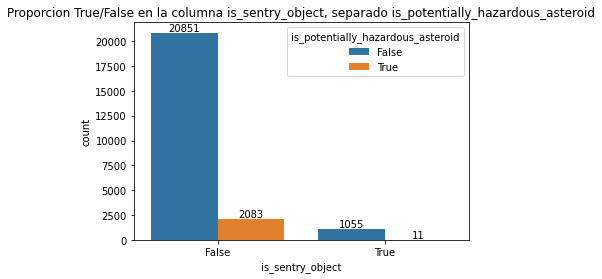

In [141]:
ax = sns.countplot(data = df_raw, x = 'is_sentry_object', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporcion True/False en la columna is_sentry_object, separado is_potentially_hazardous_asteroid')
plt.show()

In [142]:
# Hay registros que son potencialmente peligrosos, pero que no se encuentran en el sistema de monitoreo Sentry

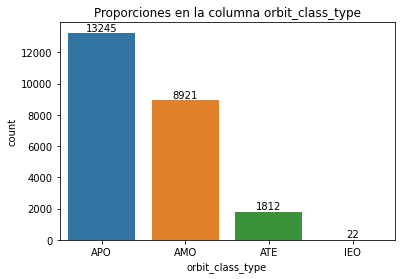

In [143]:
# Distribucion de categorias en columna 'orbit_class_type'

ax = sns.countplot(x = df_raw['orbit_class_type'])
ax.bar_label(ax.containers[0])
plt.title('Proporciones en la columna orbit_class_type')
plt.show()

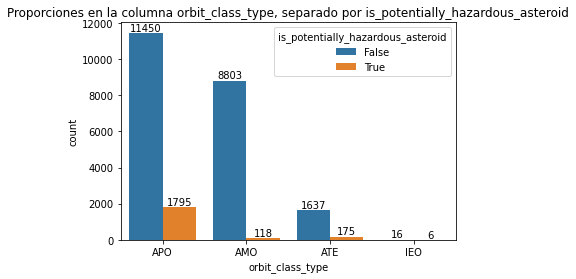

In [144]:
ax = sns.countplot(data = df_raw, x = 'orbit_class_type', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporciones en la columna orbit_class_type, separado por is_potentially_hazardous_asteroid')
plt.show()

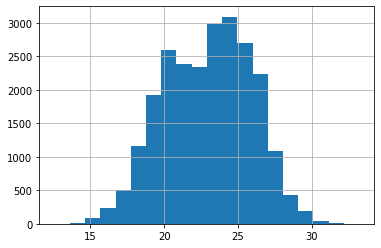

In [145]:
# Distribucion de valores de la columna 'absolute_magnitude_h'

df_raw['absolute_magnitude_h'].hist(bins = 20)
plt.show()

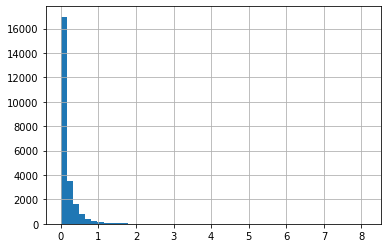

In [ ]:
# Distribucion de valorea de la columna 'kilometers_estimated_diameter_min'

df_raw['kilometers_estimated_diameter_min'].hist(bins=50)
plt.show()

# El mayor valor registrado es 8.1013048824

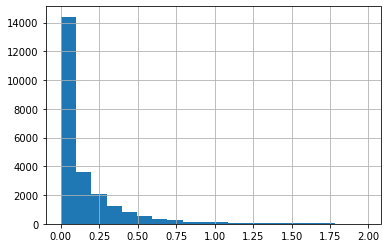

In [ ]:
# Se acotan superiormente los valores de la columna para graficar y ver mejor la distribucion, ya que esta presenta distribucion
# con marcado sesgo positivo

df_raw[df_raw['kilometers_estimated_diameter_min'] < 2]['kilometers_estimated_diameter_min'].hist(bins=20)
plt.show()

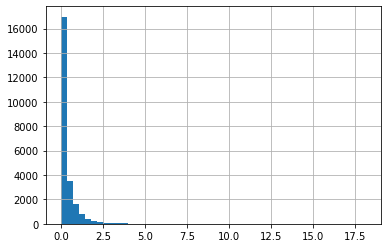

In [ ]:
# distribucion de valores de la columna 'kilometers_estimated_diameter_max'

df_raw['kilometers_estimated_diameter_max'].hist(bins=50)
plt.show()

# El mayor valor registrado es 18.1150684236

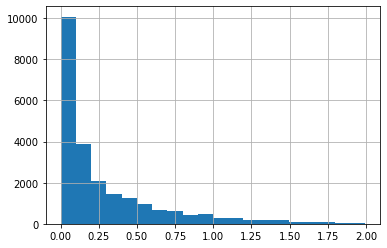

In [ ]:
# Igual que antes, se acotan los valores para poder apreciar mejor la grafica, debido al marcado sesgo positivo de la
# distribucion

df_raw[df_raw['kilometers_estimated_diameter_max'] < 2]['kilometers_estimated_diameter_max'].hist(bins=20)
plt.show()

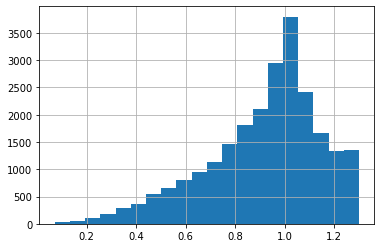

In [ ]:
# Distribucion de valores de la columna 'perihelion_distance'

df_raw['perihelion_distance'].hist(bins=20)
plt.show()

# La distribucion de esta columna en cambio presenta sesgo negativo

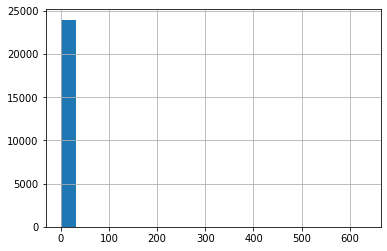

In [ ]:
# Distribucion de valores de la columna 'aphelion_distance'

df_raw['aphelion_distance'].hist(bins=20)
plt.show()

# El vmayor valor registrado es 631.8954563363584

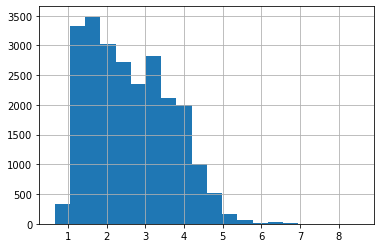

In [ ]:
# Se acotan los valores de la columna para poder apreciar mejor la distribucion

df_raw[df_raw['aphelion_distance'] < 10]['aphelion_distance'].hist(bins=20)
plt.show()

# Efectivamente esta distribucion tambien presenta sesgo positivo

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 24000 non-null  int64  
 1   name                               24000 non-null  object 
 2   absolute_magnitude_h               23992 non-null  float64
 3   is_potentially_hazardous_asteroid  24000 non-null  bool   
 4   is_sentry_object                   24000 non-null  bool   
 5   kilometers_estimated_diameter_min  23992 non-null  float64
 6   kilometers_estimated_diameter_max  23992 non-null  float64
 7   orbit_id                           24000 non-null  object 
 8   orbit_class_type                   24000 non-null  object 
 9   perihelion_distance                24000 non-null  float64
 10  aphelion_distance                  24000 non-null  float64
 11  first_observation_date             24000 non-null  obj

#### Transformacion de datos

- Vamos a convertir a datatime dtype a las columnas 'first_observation_date' y 'last_observation_date'
- Las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object' se encodean en 0 y 1
- La columna 'orbit_class_type' puede encodearse en 0, 1, 2 y 3 por tener 4 categorias diferentes
- La columnas 'orbit_id' podrian pasarse a tipo numerico, verificarlo
- Hay columnas que tienen datos faltantes, analizar situacion

In [159]:
# df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date']) - Error: Unknown string format: 2008-??-??

# Hay un valor en la columna 'first_observation_date' que vale '2008-??-??', por lo cual
# no es posible convertirlo a datetime tipo de dato. Entonces procedemos a borrar ese registro

In [160]:
df_raw[df_raw['first_observation_date'] == '2008-??-??']

# El registro a eliminar corresponde a la categoria mayoritaria de la columna 'is_potentially_hazardous_asteroid' 

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
20702,3843794,(2019 RN1),20.6,False,False,0.20163,0.450858,MPO508629,AMO,1.077174,1.865083,2008-??-??,2019-09-06,Near-Earth asteroid orbits similar to that of ...


In [161]:
df_raw = df_raw.drop(df_raw[df_raw['first_observation_date'] == '2008-??-??'].index[0])

In [162]:
# Transformando a datetime tipo de dato

df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date'])
df_raw['last_observation_date'] = pd.to_datetime(df_raw['last_observation_date'])


In [163]:
# Transformacion a 0 y 1 de las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object'

df_raw['is_potentially_hazardous_asteroid'] = pd.Categorical(df_raw['is_potentially_hazardous_asteroid'])
df_raw['is_potentially_hazardous_asteroid'] = df_raw['is_potentially_hazardous_asteroid'].cat.codes

df_raw['is_sentry_object'] = pd.Categorical(df_raw['is_sentry_object'])
df_raw['is_sentry_object'] = df_raw['is_sentry_object'].cat.codes

In [164]:
# Transformando las categorias de 'orbit_class_type' a 0, 1, 2 y 3

df_raw['orbit_class_type'] = pd.Categorical(df_raw['orbit_class_type'])
df_raw['orbit_class_type'] = df_raw['orbit_class_type'].cat.codes

In [165]:
# Verificando valores de la columna 'orbit_id'

df_raw['orbit_id'].sample(10)

18779      6
11532     44
15584      4
14083     14
20605      7
5129      13
656      153
2018      41
4535      11
13708     21
Name: orbit_id, dtype: object

In [166]:
df_raw[np.logical_not(df_raw['orbit_id'].str.isnumeric())]

# El dataset contiene solamente dos valores no numericos en la columna orbit_id, y ademas pertenecen a la categoria mayoritaria de nuestro target, por lo que podemos eliminarlas

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
10055,3645194,(2013 NE24),27.3,0,0,0.009216,0.020608,E2021-CI3,1,0.944657,4.634736,2013-07-14,2013-07-15,Near-Earth asteroid orbits which cross the Ear...
14813,3759689,(2016 RM41),25.3,0,0,0.023150,0.051765,MPO392510,0,1.050360,4.923787,2016-09-10,2016-09-11,Near-Earth asteroid orbits similar to that of ...


In [167]:
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'E2021-CI3'].index[0])
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'MPO392510'].index[0])

In [168]:
df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id'])

In [169]:
# Terminar de transformar a cateorica las columnas 'name' y 'orbit_class_description'

df_raw['name'] = pd.Categorical(df_raw['name'])
df_raw['orbit_class_description'] = pd.Categorical(df_raw['orbit_class_description'])

In [170]:
df_raw.info()

# Las columnas 'absolute_magnitude_h', 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan valores faltantes
# Se procede a llenarlos con las mediana de su columna correspondiente

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23997 entries, 0 to 23999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 23997 non-null  int64         
 1   name                               23997 non-null  category      
 2   absolute_magnitude_h               23989 non-null  float64       
 3   is_potentially_hazardous_asteroid  23997 non-null  int8          
 4   is_sentry_object                   23997 non-null  int8          
 5   kilometers_estimated_diameter_min  23989 non-null  float64       
 6   kilometers_estimated_diameter_max  23989 non-null  float64       
 7   orbit_id                           23997 non-null  int64         
 8   orbit_class_type                   23997 non-null  int8          
 9   perihelion_distance                23997 non-null  float64       
 10  aphelion_distance                 

In [171]:
# Sustituyendo los valores faltantes de las columnas 'absolute_magnitude_h', 'kilometers_estimated_diameter_min'
# y 'kilometers_estimated_diameter_max' por sus respectivas medianas
# Esto porque las columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan distribuciones
# con sesgo positivo importante.

imputer_median1 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['absolute_magnitude_h'] = imputer_median1.fit_transform(df_raw[['absolute_magnitude_h']])

imputer_median2 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['kilometers_estimated_diameter_min'] = imputer_median2.fit_transform(df_raw[['kilometers_estimated_diameter_min']])

imputer_median3 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['kilometers_estimated_diameter_max'] = imputer_median3.fit_transform(df_raw[['kilometers_estimated_diameter_max']])

In [172]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23997 entries, 0 to 23999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 23997 non-null  int64         
 1   name                               23997 non-null  category      
 2   absolute_magnitude_h               23997 non-null  float64       
 3   is_potentially_hazardous_asteroid  23997 non-null  int8          
 4   is_sentry_object                   23997 non-null  int8          
 5   kilometers_estimated_diameter_min  23997 non-null  float64       
 6   kilometers_estimated_diameter_max  23997 non-null  float64       
 7   orbit_id                           23997 non-null  int64         
 8   orbit_class_type                   23997 non-null  int8          
 9   perihelion_distance                23997 non-null  float64       
 10  aphelion_distance                 

In [ ]:
df_raw.sample(5)

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
11085,3670717,(2014 JL25),23.0,0,0,0.066766,0.149293,28,APO,0.994993,4.799721,2014-05-04,2014-06-06,Near-Earth asteroid orbits which cross the Ear...
3880,3160741,(2003 SS84),21.8,1,0,0.116026,0.259442,44,APO,0.827258,3.034454,2003-09-20,2020-03-22,Near-Earth asteroid orbits which cross the Ear...
8588,3589298,(2011 WN46),21.1,1,0,0.160160,0.358129,6,APO,0.670818,1.620694,2011-11-27,2011-12-07,Near-Earth asteroid orbits which cross the Ear...
23808,54054750,(2020 TJ),24.9,0,0,0.027833,0.062236,8,APO,1.007556,2.233612,2020-10-05,2020-10-23,Near-Earth asteroid orbits which cross the Ear...
19413,3837824,(2019 AL10),25.2,0,0,0.024241,0.054205,5,AMO,1.036728,2.430705,2019-01-11,2019-02-05,Near-Earth asteroid orbits similar to that of ...


In [173]:
# Vamos a hacer un analisis de la columna 'orbit_class_description' para observar las descripciones y evaluar si pueden haber aportes valiosos de informacion

df_raw['orbit_class_description'].unique()

['Near-Earth asteroid orbits which cross the Ea..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'An asteroid orbit contained entirely within t...]
Categories (4, object): ['An asteroid orbit contained entirely within t..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits which cross the Ea...]

In [174]:
# La columna solo contiene 4 tipos de descripciones, entonces vamos a encodearla

df_raw['orbit_class_description'] = pd.Categorical(df_raw['orbit_class_description'])
df_raw['orbit_class_description'] = df_raw['orbit_class_description'].cat.codes

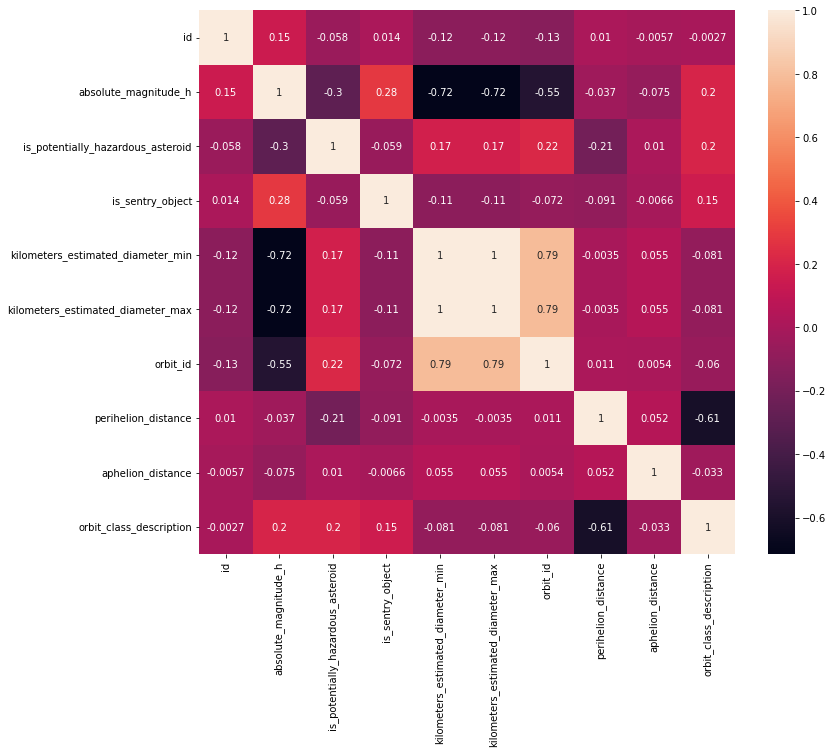

In [ ]:
# Correlaciones

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_raw.corr(), annot = True, ax=ax)
plt.show()

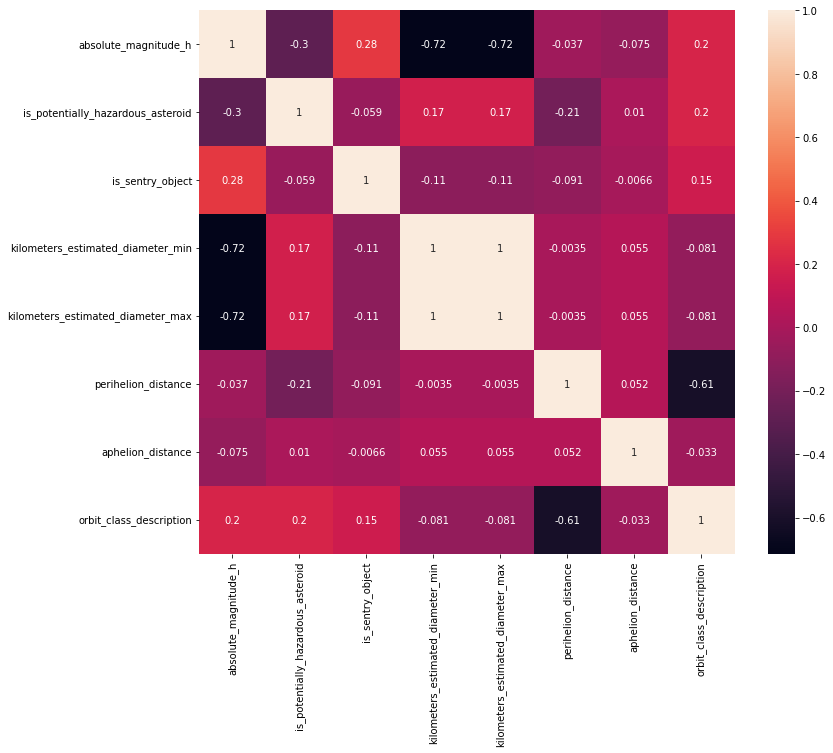

In [ ]:
# Buscar correlaciones con columnas de identificacion (id y orbit_id) no tiene sentido asi que volvemos a hacer la correlacion sin ellas

df_wo_ids = df_raw.drop(columns = ['id', 'orbit_id'])

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_wo_ids.corr(), annot = True, ax=ax)
plt.show()

#### Observaciones:
(Consideramos fuerte correlacion por encima de 0.75 (o por debajo de -0.75))

No hay correlaciones fuertes respecto a nuestro target

Las columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan las mismas correlaciones con las demas variables, ya que sus valores son muy similares, por lo que para la aplicacion de algoritmos de clasificacion solo es necesario quedarnos con una de ellas

In [ ]:
diff = df_raw['kilometers_estimated_diameter_max'] - df_raw['kilometers_estimated_diameter_min']
diff.mean()

#Aqui corroboramos que la diferencia entre ambas columnas es muy pequeña, como habiamos mencionado anteriormente

0.20735343592599492

In [175]:
# Vamos a eliminar la columna kilometers_estimated_diameter_min y renombrar kilometers_estimated_diameter_max a kilometers_estimated_diameter

df_raw.drop(columns = ['kilometers_estimated_diameter_min'], inplace = True)
df_raw.rename(columns = {'kilometers_estimated_diameter_max':'kilometers_estimated_diameter'}, inplace = True)

In [176]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23997 entries, 0 to 23999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 23997 non-null  int64         
 1   name                               23997 non-null  category      
 2   absolute_magnitude_h               23997 non-null  float64       
 3   is_potentially_hazardous_asteroid  23997 non-null  int8          
 4   is_sentry_object                   23997 non-null  int8          
 5   kilometers_estimated_diameter      23997 non-null  float64       
 6   orbit_id                           23997 non-null  int64         
 7   orbit_class_type                   23997 non-null  int8          
 8   perihelion_distance                23997 non-null  float64       
 9   aphelion_distance                  23997 non-null  float64       
 10  first_observation_date            

In [ ]:
# ATACAR IMBALANCED SITUATION

# Para el resampling, lo saque del code de decision tree

# df_majority = df[(df["Outcome"]==0)]
# df_minority = df[(df["Outcome"]==1)]
# df_minority_upsampled = resample(df_minority,replace=True,n_samples=400,random_state=42)
# df = pd.concat([df_minority_upsampled,df_majority])
# df["Outcome"].value_counts()

## Aplicacion de Decision Tree

## Aplicacion de Random Forest

## Aplicacion de XGBoost